In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

CREATING THE DATAFRAME OF PAIRS OF DIRECTORS AND ACTORS

In [2]:
movie_industry = pd.read_csv("../data/movie_industry.csv", encoding = "ISO-8859-1" )
movie_industry.loc[movie_industry.rating == "Not specified", "rating"] = "NOT RATED"
movie_industry.loc[movie_industry.rating == "UNRATED", "rating"] = "NOT RATED"
movie_industry.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [3]:
val_genre=movie_industry['genre'].value_counts()
val_genre


Comedy       2080
Drama        1444
Action       1331
Crime         522
Adventure     392
Biography     359
Horror        277
Animation     277
Mystery        38
Fantasy        32
Thriller       18
Romance        15
Family         14
Sci-Fi         13
Musical         4
Western         2
War             2
Name: genre, dtype: int64

In [4]:
picked_genre = val_genre[:8].index
picked_genre


Index(['Comedy', 'Drama', 'Action', 'Crime', 'Adventure', 'Biography',
       'Horror', 'Animation'],
      dtype='object')

In [5]:
movie_industry['genre'][~ movie_industry['genre'].isin(picked_genre)] = 'Other'
movie_industry['genre'].value_counts()

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Comedy       2080
Drama        1444
Action       1331
Crime         522
Adventure     392
Biography     359
Horror        277
Animation     277
Other         138
Name: genre, dtype: int64

In [6]:
g = pd.get_dummies

In [7]:
class Graph:
    """ Wrapper class Graph to create a bipartite graph
    Takes in the following paramaters
    directors_to_actors_relation : Dataframe with the data for directors and actors
    weight func : function which defined the weight of an edge. Takes the dateframe to calcuate weights from and
    the nodes values to calculate for
    weight_func_args : column names used to calculate the weights
    director_column : Column name for director
    actor_column : Column name for actor, 
    bipartite : default true
    """
    def __init__(self, 
                 directors_to_actors_relation, 
                 weight_func, 
                 weight_func_args, 
                 director_column="director", 
                 actor_column="star", 
                 bipartite=True):
        self.G = nx.Graph()
        
        directors = set(directors_to_actors_relation[director_column].values)
        actors = set(directors_to_actors_relation[actor_column].values)
    
        #store the director node as a tuple with director name and boolean True to indicate director
        for director in directors:
            self.G.add_node((director, True))
            
        #store the actor node as a tuple with actor name and boolean False to indicate actor
        for actor in actors:
            self.G.add_node((actor, False))

        #add weights to all edges
        for director in directors:
            rows = directors_to_actors_relation[directors_to_actors_relation[director_column] == director]
            for index in rows.index.values:
                self.G.add_edge((director, True), 
                                (rows.loc[index, actor_column], False), 
                                weight=weight_func(*[rows.loc[index, i] for i in weight_func_args], directors_to_actors_relation))             

In [8]:
#calcualtes edge weight as the number of collaborations
#takes in director name, star name and data to calculate weight from
def example_weight_func(director, star, df):
    return len(df.loc[((df["director"] == director) & (df["star"] == star))])

In [9]:
storage = Graph(movie_industry, example_weight_func, ["director", "star"])

In [10]:
directors = list(set(movie_industry["director"].values))
actors = list(set(movie_industry["star"].values))

In [11]:
collabs = []
for director in directors:
    for actor in actors:
        if storage.G.get_edge_data((director, True), (actor, False)):
            collabs.append(storage.G.get_edge_data((director, True), (actor, False))["weight"])
        else:
            collabs.append(0)

In [12]:
res =  [director for director in directors for i in range(len(actors))] 
df = pd.DataFrame({"director": res, 
                   "actor": actors*len(directors),
                  "collabs": collabs})
df.head()

,director,actor,collabs
0,Drew Barrymore,Drew Barrymore,0
1,Drew Barrymore,Max Parrish,0
2,Drew Barrymore,Bill Pullman,0
3,Drew Barrymore,Robin Tunney,0
4,Drew Barrymore,Salma Hayek,0


In [13]:
df['collabs'].value_counts()

0     6902230
1        5929
2         299
3          52
4          13
5           5
6           4
11          1
10          1
8           1
7           1
Name: collabs, dtype: int64

ADDING AND TESTING COVARIATES

In [14]:
df["collab indicator"] = (df.collabs > 0)*1

In [15]:
def add_feature_actor(feature_total, feature_mean, feature_name):
    for actor in actors:
        temp = movie_industry[movie_industry.star ==  actor]
        sum_feature = sum(temp[feature_name].values)
        mean_feature = np.mean(temp[feature_name].values)
        feature_total[actor] = sum_feature
        feature_mean[actor] = mean_feature
        
def add_feature_director(feature_total, feature_mean, feature_name):
    for director in directors:
        temp = movie_industry[movie_industry.director ==  director]
        sum_feature = sum(temp[feature_name].values)
        mean_feature = np.mean(temp[feature_name].values)
        feature_total[director] = sum_feature
        feature_mean[director] = mean_feature

### budget

In [16]:
actor_total_budget = {}
actor_mean_budget = {}
add_feature_actor(actor_total_budget, actor_mean_budget, 'budget')
df["actor_total_budget"] = df.actor.map(actor_total_budget)
df["actor_mean_budget"] = df.actor.map(actor_mean_budget)

director_total_budget = {}
director_mean_budget = {}
add_feature_director(director_total_budget, director_mean_budget, 'budget')
df["director_total_budget"] = df.director.map(director_total_budget)
df["director_mean_budget"] = df.director.map(director_mean_budget)

df["total_budget_diff"] = abs(df.director_total_budget - df.actor_total_budget)
df["mean_budget_diff"] = abs(df.director_mean_budget - df.actor_mean_budget)
df.head()

,director,actor,collabs,collab indicator,actor_total_budget,actor_mean_budget,director_total_budget,director_mean_budget,total_budget_diff,mean_budget_diff
0,Drew Barrymore,Drew Barrymore,0,0,359800000.0,2.998333e+07,15000000.0,15000000.0,344800000.0,1.498333e+07
1,Drew Barrymore,Max Parrish,0,0,0.0,0.000000e+00,15000000.0,15000000.0,15000000.0,1.500000e+07
2,Drew Barrymore,Bill Pullman,0,0,79000000.0,1.580000e+07,15000000.0,15000000.0,64000000.0,8.000000e+05
3,Drew Barrymore,Robin Tunney,0,0,15000000.0,1.500000e+07,15000000.0,15000000.0,0.0,0.000000e+00
4,Drew Barrymore,Salma Hayek,0,0,12000000.0,6.000000e+06,15000000.0,15000000.0,3000000.0,9.000000e+06


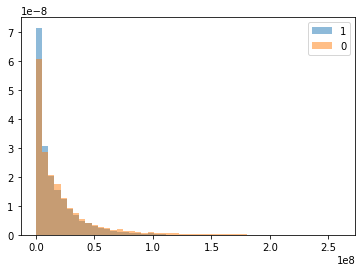

In [17]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.mean_budget_diff.values), max(df_dropped.mean_budget_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].mean_budget_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].mean_budget_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()



In [18]:
from scipy.stats import ttest_ind
print('mean_budget_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].mean_budget_diff.values)))
print('mean_budget_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].mean_budget_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].mean_budget_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_budget_diff.values, 
                      equal_var=False)

mean_budget_diff variance in pairs w/ collab is  364783687588295.75
mean_budget_diff variance in pairs w/o collab is  811132968046382.9


Ttest_indResult(statistic=-23.274224123640657, pvalue=4.878637649018597e-115)

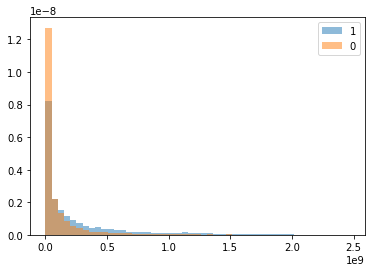

In [19]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.total_budget_diff.values), max(df_dropped.total_budget_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].total_budget_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].total_budget_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [20]:
print('total_budget_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].total_budget_diff.values)))
print('total_budget_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].total_budget_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].total_budget_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_budget_diff.values, 
                      equal_var=False)

total_budget_diff variance in pairs w/ collab is  1.5498155563507763e+17
total_budget_diff variance in pairs w/o collab is  4.9954864773607944e+16


Ttest_indResult(statistic=30.707468124240446, pvalue=4.1316454624320973e-193)

### score

In [21]:
actor_total_score = {}
actor_mean_score = {}
add_feature_actor(actor_total_score, actor_mean_score, 'score')
df["actor_total_score"] = df.actor.map(actor_total_score)
df["actor_mean_score"] = df.actor.map(actor_mean_score)

director_total_score = {}
director_mean_score = {}
add_feature_director(director_total_score, director_mean_score, 'score')
df["director_total_score"] = df.director.map(director_total_score)
df["director_mean_score"] = df.director.map(director_mean_score)

df["total_score_diff"] = abs(df.director_total_score - df.actor_total_score)
df["mean_score_diff"] = abs(df.director_mean_score - df.actor_mean_score)
df.head()

,director,actor,collabs,collab indicator,actor_total_budget,actor_mean_budget,director_total_budget,director_mean_budget,total_budget_diff,mean_budget_diff,actor_total_score,actor_mean_score,director_total_score,director_mean_score,total_score_diff,mean_score_diff
0,Drew Barrymore,Drew Barrymore,0,0,359800000.0,2.998333e+07,15000000.0,15000000.0,344800000.0,1.498333e+07,69.8,5.816667,6.9,6.9,62.9,1.083333
1,Drew Barrymore,Max Parrish,0,0,0.0,0.000000e+00,15000000.0,15000000.0,15000000.0,1.500000e+07,6.0,6.000000,6.9,6.9,0.9,0.900000
2,Drew Barrymore,Bill Pullman,0,0,79000000.0,1.580000e+07,15000000.0,15000000.0,64000000.0,8.000000e+05,33.2,6.640000,6.9,6.9,26.3,0.260000
3,Drew Barrymore,Robin Tunney,0,0,15000000.0,1.500000e+07,15000000.0,15000000.0,0.0,0.000000e+00,6.3,6.300000,6.9,6.9,0.6,0.600000
4,Drew Barrymore,Salma Hayek,0,0,12000000.0,6.000000e+06,15000000.0,15000000.0,3000000.0,9.000000e+06,13.8,6.900000,6.9,6.9,6.9,0.000000


In [22]:
movie_industry[movie_industry.director=='Neal Brennan']

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
5254,0.0,Paramount Vantage,USA,Neal Brennan,Comedy,15102127.0,"The Goods: Live Hard, Sell Hard",R,2009-08-14,89,5.8,Jeremy Piven,18361,Andy Stock,2009


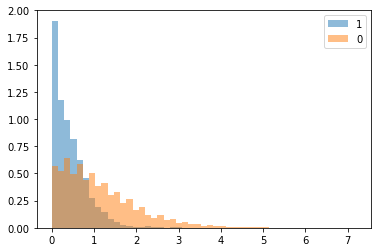

In [23]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.mean_score_diff.values), max(df_dropped.mean_score_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].mean_score_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].mean_score_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()


In [24]:
print('mean_score_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].mean_score_diff.values)))
print('mean_score_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].mean_score_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].mean_score_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_score_diff.values, 
                      equal_var=False)

mean_score_diff variance in pairs w/ collab is  0.1671648849403833
mean_score_diff variance in pairs w/o collab is  0.7926996535043869


Ttest_indResult(statistic=-132.7346742573873, pvalue=0.0)

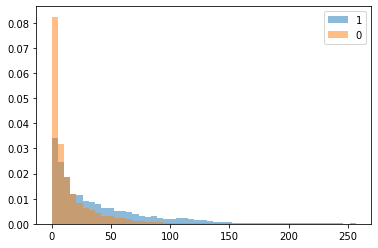

In [25]:
bins = np.linspace(min(df_dropped.total_score_diff.values), max(df_dropped.total_score_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].total_score_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].total_score_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()


In [26]:
print('total_score_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].total_score_diff.values)))
print('total_score_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].total_score_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].total_score_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_score_diff.values, 
                      equal_var=False)

total_score_diff variance in pairs w/ collab is  1951.7441230141521
total_score_diff variance in pairs w/o collab is  714.3838449451066


Ttest_indResult(statistic=40.11154851316732, pvalue=0.0)

### votes

In [27]:
actor_total_votes = {}
actor_mean_votes = {}
add_feature_actor(actor_total_votes, actor_mean_votes, 'votes')
df["actor_total_votes"] = df.actor.map(actor_total_votes)
df["actor_mean_votes"] = df.actor.map(actor_mean_votes)

director_total_votes = {}
director_mean_votes = {}
add_feature_director(director_total_votes, director_mean_votes, 'votes')
df["director_total_votes"] = df.director.map(director_total_votes)
df["director_mean_votes"] = df.director.map(director_mean_votes)

df["total_votes_diff"] = abs(df.director_total_votes - df.actor_total_votes)
df["mean_votes_diff"] = abs(df.director_mean_votes - df.actor_mean_votes)
df.head()

,director,actor,collabs,collab indicator,actor_total_budget,actor_mean_budget,director_total_budget,director_mean_budget,total_budget_diff,mean_budget_diff,...,director_total_score,director_mean_score,total_score_diff,mean_score_diff,actor_total_votes,actor_mean_votes,director_total_votes,director_mean_votes,total_votes_diff,mean_votes_diff
0,Drew Barrymore,Drew Barrymore,0,0,359800000.0,2.998333e+07,15000000.0,15000000.0,344800000.0,1.498333e+07,...,6.9,6.9,62.9,1.083333,425247,35437.25,58138,58138.0,367109,22700.75
1,Drew Barrymore,Max Parrish,0,0,0.0,0.000000e+00,15000000.0,15000000.0,15000000.0,1.500000e+07,...,6.9,6.9,0.9,0.900000,371,371.00,58138,58138.0,57767,57767.00
2,Drew Barrymore,Bill Pullman,0,0,79000000.0,1.580000e+07,15000000.0,15000000.0,64000000.0,8.000000e+05,...,6.9,6.9,26.3,0.260000,236285,47257.00,58138,58138.0,178147,10881.00
3,Drew Barrymore,Robin Tunney,0,0,15000000.0,1.500000e+07,15000000.0,15000000.0,0.0,0.000000e+00,...,6.9,6.9,0.6,0.600000,62195,62195.00,58138,58138.0,4057,4057.00
4,Drew Barrymore,Salma Hayek,0,0,12000000.0,6.000000e+06,15000000.0,15000000.0,3000000.0,9.000000e+06,...,6.9,6.9,6.9,0.000000,85589,42794.50,58138,58138.0,27451,15343.50


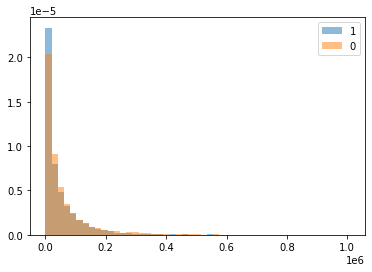

In [28]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.mean_votes_diff.values), max(df_dropped.mean_votes_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].mean_votes_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].mean_votes_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [29]:
print('mean_votes_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].mean_votes_diff.values)))
print('mean_votes_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].mean_votes_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].mean_votes_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_votes_diff.values, 
                      equal_var=False)

mean_votes_diff variance in pairs w/ collab is  5024807374.804754
mean_votes_diff variance in pairs w/o collab is  6901274259.018731


Ttest_indResult(statistic=-10.44687459264266, pvalue=2.433289919493234e-25)

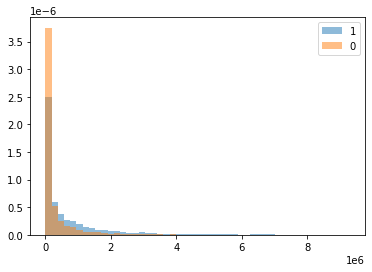

In [30]:
bins = np.linspace(min(df_dropped.total_votes_diff.values), max(df_dropped.total_votes_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].total_votes_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].total_votes_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [31]:
print('total_votes_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].total_votes_diff.values)))
print('total_votes_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].total_votes_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].total_votes_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_votes_diff.values, 
                      equal_var=False)

total_votes_diff variance in pairs w/ collab is  1614598418040.543
total_votes_diff variance in pairs w/o collab is  527109690822.26184


Ttest_indResult(statistic=28.404723742823816, pvalue=4.0248852997916604e-167)

### runtime

In [32]:
actor_total_runtime = {}
actor_mean_runtime = {}
add_feature_actor(actor_total_runtime, actor_mean_runtime, 'runtime')
df["actor_total_runtime"] = df.actor.map(actor_total_runtime)
df["actor_mean_runtime"] = df.actor.map(actor_mean_runtime)

director_total_runtime = {}
director_mean_runtime = {}
add_feature_director(director_total_runtime, director_mean_runtime, 'runtime')
df["director_total_runtime"] = df.director.map(director_total_runtime)
df["director_mean_runtime"] = df.director.map(director_mean_runtime)

df["total_runtime_diff"] = abs(df.director_total_runtime - df.actor_total_runtime)
df["mean_runtime_diff"] = abs(df.director_mean_runtime - df.actor_mean_runtime)
df.head()

,director,actor,collabs,collab indicator,actor_total_budget,actor_mean_budget,director_total_budget,director_mean_budget,total_budget_diff,mean_budget_diff,...,director_total_votes,director_mean_votes,total_votes_diff,mean_votes_diff,actor_total_runtime,actor_mean_runtime,director_total_runtime,director_mean_runtime,total_runtime_diff,mean_runtime_diff
0,Drew Barrymore,Drew Barrymore,0,0,359800000.0,2.998333e+07,15000000.0,15000000.0,344800000.0,1.498333e+07,...,58138,58138.0,367109,22700.75,1256,104.666667,111,111.0,1145,6.333333
1,Drew Barrymore,Max Parrish,0,0,0.0,0.000000e+00,15000000.0,15000000.0,15000000.0,1.500000e+07,...,58138,58138.0,57767,57767.00,92,92.000000,111,111.0,19,19.000000
2,Drew Barrymore,Bill Pullman,0,0,79000000.0,1.580000e+07,15000000.0,15000000.0,64000000.0,8.000000e+05,...,58138,58138.0,178147,10881.00,533,106.600000,111,111.0,422,4.400000
3,Drew Barrymore,Robin Tunney,0,0,15000000.0,1.500000e+07,15000000.0,15000000.0,0.0,0.000000e+00,...,58138,58138.0,4057,4057.00,101,101.000000,111,111.0,10,10.000000
4,Drew Barrymore,Salma Hayek,0,0,12000000.0,6.000000e+06,15000000.0,15000000.0,3000000.0,9.000000e+06,...,58138,58138.0,27451,15343.50,257,128.500000,111,111.0,146,17.500000


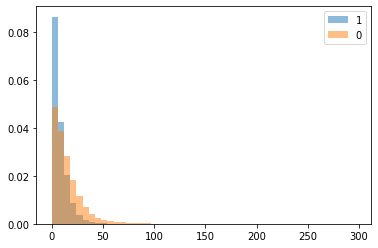

In [33]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.mean_runtime_diff.values), max(df_dropped.mean_runtime_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].mean_runtime_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].mean_runtime_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [34]:
print('mean_runtime_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].mean_runtime_diff.values)))
print('mean_runtime_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].mean_runtime_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].mean_runtime_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_runtime_diff.values, 
                      equal_var=False)

mean_runtime_diff variance in pairs w/ collab is  67.40045405463802
mean_runtime_diff variance in pairs w/o collab is  277.3293865817507


Ttest_indResult(statistic=-73.49696909798462, pvalue=0.0)

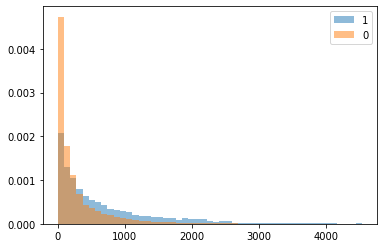

In [35]:
bins = np.linspace(min(df_dropped.total_runtime_diff.values), max(df_dropped.total_runtime_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].total_runtime_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].total_runtime_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [36]:
print('total_runtime_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].total_runtime_diff.values)))
print('total_runtime_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].total_runtime_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].total_runtime_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_runtime_diff.values, 
                      equal_var=False)

total_runtime_diff variance in pairs w/ collab is  595748.240071503
total_runtime_diff variance in pairs w/o collab is  216318.20321231594


Ttest_indResult(statistic=39.887490193490606, pvalue=0.0)

### oscar nomination

In [37]:
oscar = pd.read_csv("../data/the_oscar_award.csv")
oscar.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


In [38]:
oscar.category = oscar.category.str.lower()
filtered = oscar[oscar.category.str.contains("(actor)|(actress)|(directing)", regex = True)]
filtered

/opt/miniconda3/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,actor,Richard Barthelmess,The Noose,False
1,1927,1928,1,actor,Emil Jannings,The Last Command,True
2,1927,1928,1,actress,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,actress,Janet Gaynor,7th Heaven,True
4,1927,1928,1,actress,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10302,2019,2020,92,directing,Martin Scorsese,The Irishman,False
10303,2019,2020,92,directing,Todd Phillips,Joker,False
10304,2019,2020,92,directing,Sam Mendes,1917,False
10305,2019,2020,92,directing,Quentin Tarantino,Once upon a Time...in Hollywood,False


In [39]:
filtered.loc[filtered.category.str.contains("(actor)|(actress)"), 'is_director'] = 0
filtered.loc[filtered.category.str.contains("directing"), 'is_director'] = 1

/opt/miniconda3/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [40]:
oscar_ppl = filtered[~filtered.name.str.contains("( and)|(,)|(and )", regex = True)]
oscar_ppl.is_director = oscar_ppl.is_director.astype(np.uint8)
oscar_ppl.head()


/opt/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,year_film,year_ceremony,ceremony,category,name,film,winner,is_director
0,1927,1928,1,actor,Richard Barthelmess,The Noose,False,0
1,1927,1928,1,actor,Emil Jannings,The Last Command,True,0
2,1927,1928,1,actress,Louise Dresser,A Ship Comes In,False,0
3,1927,1928,1,actress,Janet Gaynor,7th Heaven,True,0
4,1927,1928,1,actress,Gloria Swanson,Sadie Thompson,False,0


In [41]:
gp_ppl = oscar_ppl.groupby(['name', 'is_director']).size().reset_index(name='nomination_counts')
gp_ppl_director = gp_ppl.groupby(['is_director']).get_group(1)
gp_ppl_actor = gp_ppl.groupby(['is_director']).get_group(0)
gp_ppl_director.head()

,name,is_director,nomination_counts
2,Adam McKay,1,2
5,Adrian Lyne,1,1
10,Akira Kurosawa,1,1
15,Alan J. Pakula,1,1
16,Alan Parker,1,2


In [42]:
gp_ppl_actor.head()

,name,is_director,nomination_counts
0,Abigail Breslin,0,1
1,Adam Driver,0,2
3,Adolph Caesar,0,1
4,Adolphe Menjou,0,1
6,Adriana Barraza,0,1


In [43]:
df_w_oscar= pd.merge(df, gp_ppl_director, left_on='director', right_on='name')
df_w_oscar= pd.merge(df_w_oscar, gp_ppl_actor, left_on='actor', right_on='name')
df_w_oscar.drop(['name_x', 'is_director_x', 'name_y', 'is_director_y'], axis=1, inplace=True)
df_w_oscar.rename(columns={'nomination_counts_x': 'director_nominations', 'nomination_counts_y': 'actor_nominations'}, inplace=True)
df_w_oscar.head()

,director,actor,collabs,collab indicator,actor_total_budget,actor_mean_budget,director_total_budget,director_mean_budget,total_budget_diff,mean_budget_diff,...,total_votes_diff,mean_votes_diff,actor_total_runtime,actor_mean_runtime,director_total_runtime,director_mean_runtime,total_runtime_diff,mean_runtime_diff,director_nominations,actor_nominations
0,Danny Boyle,Salma Hayek,0,0,12000000.0,6000000.0,1.590000e+08,1.445455e+07,1.470000e+08,8.454545e+06,...,2474748,189963.409091,257,128.5,1160,105.454545,903,23.045455,1,1
1,Ridley Scott,Salma Hayek,0,0,12000000.0,6000000.0,1.480500e+09,7.792105e+07,1.468500e+09,7.192105e+07,...,4281016,187026.815789,257,128.5,2536,133.473684,2279,4.973684,3,1
2,Fernando Meirelles,Salma Hayek,0,0,12000000.0,6000000.0,2.830000e+07,7.075000e+06,1.630000e+07,1.075000e+06,...,688879,150822.500000,257,128.5,490,122.500000,233,6.000000,1,1
3,Roberto Benigni,Salma Hayek,0,0,12000000.0,6000000.0,2.000000e+07,5.000000e+06,8.000000e+06,1.000000e+06,...,413847,82064.500000,257,128.5,438,109.500000,181,19.000000,1,1
4,Denis Villeneuve,Salma Hayek,0,0,12000000.0,6000000.0,1.298000e+08,2.163333e+07,1.178000e+08,1.563333e+07,...,1231978,176800.000000,257,128.5,699,116.500000,442,12.000000,1,1


In [44]:
df_w_oscar['nominations_diff']=df_w_oscar['director_nominations'] - df_w_oscar['actor_nominations']
df_w_oscar.head()

,director,actor,collabs,collab indicator,actor_total_budget,actor_mean_budget,director_total_budget,director_mean_budget,total_budget_diff,mean_budget_diff,...,mean_votes_diff,actor_total_runtime,actor_mean_runtime,director_total_runtime,director_mean_runtime,total_runtime_diff,mean_runtime_diff,director_nominations,actor_nominations,nominations_diff
0,Danny Boyle,Salma Hayek,0,0,12000000.0,6000000.0,1.590000e+08,1.445455e+07,1.470000e+08,8.454545e+06,...,189963.409091,257,128.5,1160,105.454545,903,23.045455,1,1,0
1,Ridley Scott,Salma Hayek,0,0,12000000.0,6000000.0,1.480500e+09,7.792105e+07,1.468500e+09,7.192105e+07,...,187026.815789,257,128.5,2536,133.473684,2279,4.973684,3,1,2
2,Fernando Meirelles,Salma Hayek,0,0,12000000.0,6000000.0,2.830000e+07,7.075000e+06,1.630000e+07,1.075000e+06,...,150822.500000,257,128.5,490,122.500000,233,6.000000,1,1,0
3,Roberto Benigni,Salma Hayek,0,0,12000000.0,6000000.0,2.000000e+07,5.000000e+06,8.000000e+06,1.000000e+06,...,82064.500000,257,128.5,438,109.500000,181,19.000000,1,1,0
4,Denis Villeneuve,Salma Hayek,0,0,12000000.0,6000000.0,1.298000e+08,2.163333e+07,1.178000e+08,1.563333e+07,...,176800.000000,257,128.5,699,116.500000,442,12.000000,1,1,0


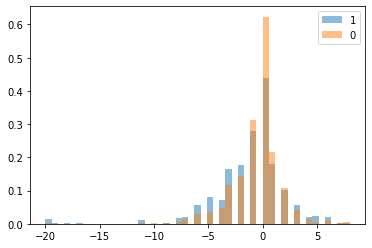

In [45]:
bins = np.linspace(min(df_w_oscar.nominations_diff.values), max(df_w_oscar.nominations_diff.values), 50)
plt.hist(df_w_oscar[df_w_oscar["collab indicator"] == 1].nominations_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_w_oscar[df_w_oscar["collab indicator"] == 0].nominations_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [46]:
print('nominations_diff variance in pairs w/ collab is  {}'.format(np.var(df_w_oscar[df_w_oscar["collab indicator"] == 1].nominations_diff.values)))
print('nominations_diff variance in pairs w/o collab is  {}'.format(np.var(df_w_oscar[df_w_oscar["collab indicator"] == 0].nominations_diff.values)))
ttest_ind(df_w_oscar[df_w_oscar["collab indicator"] == 1].nominations_diff.values, 
                      df_w_oscar[df_w_oscar["collab indicator"] == 0].nominations_diff.values, 
                      equal_var=False)

nominations_diff variance in pairs w/ collab is  11.675624990825147
nominations_diff variance in pairs w/o collab is  5.747848063463027


Ttest_indResult(statistic=-3.9763645704487445, pvalue=7.977315478395336e-05)

### genre

In [47]:
genre = np.unique(movie_industry.genre.values)
genre

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Horror', 'Other'], dtype=object)

In [48]:
dir_genre_prop = {}
for director in directors:
    temp = movie_industry[movie_industry.director == director].groupby(["genre"])["director"].count()
    prop = []
    total = sum(temp.values)
    for category in genre:
        if category in temp.index:
            prop.append(temp[category]/total)
        else:
            prop.append(0)
    dir_genre_prop[director] = np.array(prop)

In [49]:
act_genre_prop = {}
for actor in actors:
    temp = movie_industry[movie_industry.star == actor].groupby(["genre"])["star"].count()
    prop = []
    total = sum(temp.values)
    for category in genre:
        if category in temp.index:
            prop.append(temp[category]/total)
        else:
            prop.append(0)
    act_genre_prop[actor] = np.array(prop)

In [50]:
%%time
genre_tvd = []
for i in df.index:
    director = df.director[i]
    actor = df.actor[i]
    tvd = sum(abs(dir_genre_prop[director] - act_genre_prop[actor]))/2
    genre_tvd.append(tvd)

CPU times: user 2min 32s, sys: 1.11 s, total: 2min 33s
Wall time: 2min 34s


In [51]:
df["genre_tvd"] = genre_tvd

In [52]:
bins = np.linspace(min(genre_tvd), max(genre_tvd), 20)
bins

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

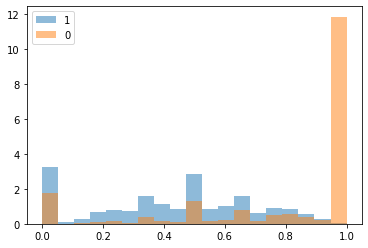

In [53]:
plt.hist(df[df["collab indicator"] == 1].genre_tvd.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df[df["collab indicator"] == 0].genre_tvd.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [54]:
ttest_ind(df[df["collab indicator"] == 1].genre_tvd.values, 
                      df[df["collab indicator"] == 0].genre_tvd.values, 
                      equal_var=False)



Ttest_indResult(statistic=-108.81833577459516, pvalue=0.0)

## Visualization

<Figure size 432x288 with 0 Axes>

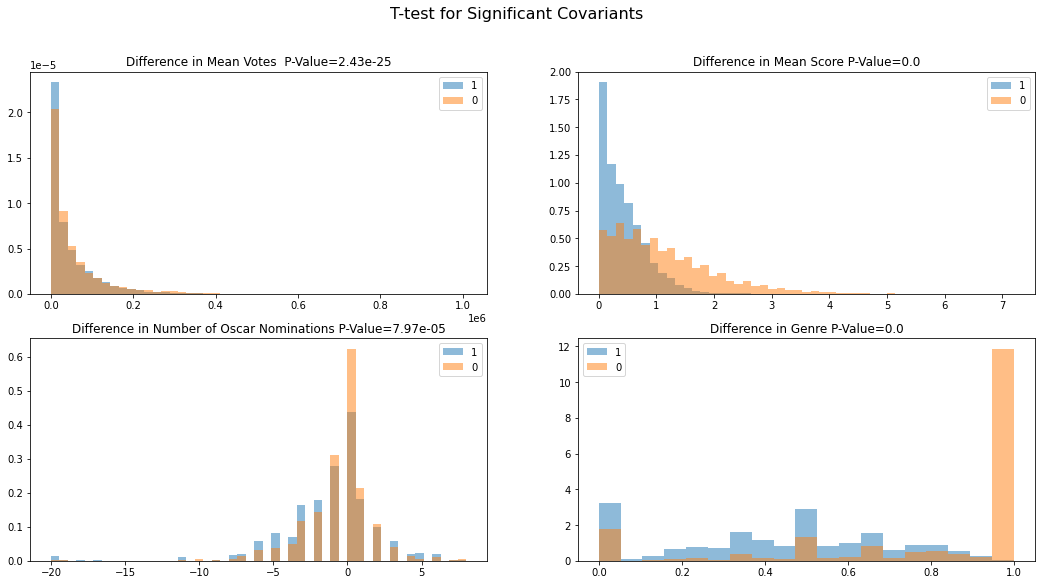

In [56]:
df_dropped = df.dropna()

fig = plt.figure()
f, axes = plt.subplots(2, 2, figsize=(18,9), sharex=False)
plt.suptitle("T-test for Significant Covariants", fontsize=16)

bins1 = np.linspace(min(df_dropped.mean_votes_diff.values), max(df_dropped.mean_votes_diff.values), 50)
axes[0, 0].hist(df_dropped[df_dropped["collab indicator"] == 1].mean_votes_diff.values, density = True, bins = bins1, label = "1", alpha = 0.5)
axes[0, 0].hist(df_dropped[df_dropped["collab indicator"] == 0].mean_votes_diff.values, density = True, bins = bins1, label = "0", alpha = 0.5)
axes[0, 0].legend()
axes[0, 0].title.set_text('Difference in Mean Votes  P-Value=2.43e-25')

bins2 = np.linspace(min(df_dropped.mean_score_diff.values), max(df_dropped.mean_score_diff.values), 50)
axes[0, 1].hist(df_dropped[df_dropped["collab indicator"] == 1].mean_score_diff.values, density = True, bins = bins2, label = "1", alpha = 0.5)
axes[0, 1].hist(df_dropped[df_dropped["collab indicator"] == 0].mean_score_diff.values, density = True, bins = bins2, label = "0", alpha = 0.5)
axes[0, 1].legend()
axes[0, 1].title.set_text('Difference in Mean Score P-Value=0.0')

bins3 = np.linspace(min(df_w_oscar.nominations_diff.values), max(df_w_oscar.nominations_diff.values), 50)
axes[1, 0].hist(df_w_oscar[df_w_oscar["collab indicator"] == 1].nominations_diff.values, density = True, bins = bins3, label = "1", alpha = 0.5)
axes[1, 0].hist(df_w_oscar[df_w_oscar["collab indicator"] == 0].nominations_diff.values, density = True, bins = bins3, label = "0", alpha = 0.5)
axes[1, 0].legend()
axes[1, 0].title.set_text('Difference in Number of Oscar Nominations P-Value=7.97e-05')

bins4 = np.linspace(min(genre_tvd), max(genre_tvd), 20)
axes[1, 1].hist(df[df["collab indicator"] == 1].genre_tvd.values, density = True, bins = bins4, label = "1", alpha = 0.5)
axes[1, 1].hist(df[df["collab indicator"] == 0].genre_tvd.values, density = True, bins = bins4, label = "0", alpha = 0.5)
axes[1, 1].legend()
axes[1, 1].title.set_text('Difference in Genre P-Value=0.0')

f.savefig('../figures/T-test for Significant Covariants.png', bbox_inches='tight')
